In [1]:
import sys
sys.path.insert(0, '..')
from eda_import import *

import pysam

from utils.parse_gtf_utils import extract_info
from utils.calc_clv_sc import gen_sc_clv_per_transcript, get_strand
from utils.cluster import cluster_clv_sites

# Extracting mapping information from annotation

In [2]:
input_gtf = '../reference_data/Homo_sapiens.GRCh37.75.gtf'

In [3]:
%%time
# http://uswest.ensembl.org/info/website/upload/gff.html
names = ['seqname', 'source', 'feature', 'start', 'end', 'score', 
         'strand', 'frame', 'attribute']
gtf_df = pd.read_csv(input_gtf, header=None, sep='\t', comment='#', 
                     low_memory=False, names=names)

CPU times: user 14.1 s, sys: 2.62 s, total: 16.7 s
Wall time: 16.7 s


In [4]:
%time extract_info(gtf_df)

extracting length...
extracting transcript id...
extracting gene id...
extracting gene name...
extracting gene source...
extracting transcript source...
extracting tag cds_end_NF...
extracting tag cds_start_NF...
CPU times: user 22.7 s, sys: 1.3 s, total: 23.9 s
Wall time: 23.9 s


In [5]:
TARGET_GENES = pd.read_csv('../reference_data/target_genes_with_type.tsv', sep='\t').Gene.values.tolist()

In [6]:
gtf_df.query('source == "protein_coding"').is_cds_end_NF.value_counts()

False    1725446
True     275608 
Name: is_cds_end_NF, dtype: int64

In [7]:
gtf_df.query('source == "nonsense_mediated_decay"').is_cds_end_NF.value_counts()

False    293097
True     374   
Name: is_cds_end_NF, dtype: int64

In [8]:
# is_cds_end_NF == True means 3' CDS incomplete
gtf_df.query('is_cds_end_NF == True').head(2)

,seqname,source,feature,start,end,score,strand,frame,len,transcript_id,gene_id,gene_name,gene_source,transcript_source,is_cds_end_NF,is_cds_start_NF
638,1,protein_coding,transcript,860260,874671,.,+,.,14412,ENST00000420190,ENSG00000187634,SAMD11,ensembl_havana,havana,True,False
639,1,protein_coding,exon,860260,860328,.,+,.,69,ENST00000420190,ENSG00000187634,SAMD11,ensembl_havana,havana,True,False


In [9]:
targeted_gtf_df = gtf_df\
    .query('gene_name in {0}'.format(TARGET_GENES))\
    .query('source in {0}'.format(['protein_coding', 'nonsense_mediated_decay']))\
    .query('is_cds_end_NF == False').copy()

In [10]:
targeted_gtf_df.query('feature == "transcript"').transcript_source.value_counts()

havana            321
ensembl_havana    226
ensembl           95 
Name: transcript_source, dtype: int64

So the majority involves mannual annotation processes, havana

In [11]:
adf = targeted_gtf_df\
    .query('feature != "gene"')\
    .groupby(['gene_name', 'transcript_id', 'seqname'])\
    .apply(gen_sc_clv_per_transcript)

In [12]:
adf.reset_index(inplace=True)

In [13]:
adf.gene_name.unique().shape

(114,)

In [14]:
adf.source.value_counts()

protein_coding             532
nonsense_mediated_decay    110
Name: source, dtype: int64

In [15]:
adf.head(2)

,gene_name,transcript_id,seqname,source,sc,clv,strand,gene_source,transcript_source,is_cds_end_NF,is_cds_start_NF
0,ABL1,ENST00000318560,9,protein_coding,133761070,133763062,+,ensembl_havana,ensembl_havana,False,False
1,AKT1,ENST00000349310,14,protein_coding,105236678,105235686,-,ensembl_havana,ensembl_havana,False,False


In [16]:
def calc_utr_beg(row):
    """calculate the beginning of 3'UTR"""
    if row.strand == '+':
        return row.sc + 1
    else:
        return row.sc - 1

adf['utr_beg'] = adf.apply(calc_utr_beg, axis=1)

In [17]:
adf.query('utr_beg == clv').source.value_counts()

protein_coding    30
Name: source, dtype: int64

Output a list of transcripts with zero-length 3' UTR

In [18]:
_cols = [
    'seqname', 'gene_name', 'strand', 'transcript_id', 
     'source', 'sc', 'utr_beg', 'clv', 'transcript_source'
]
new_names = ['Chromosome', 'Gene', 'Strand', 'Transcript ID', 
             'Source',  'Stop codon', "3' UTR start", "3' UTR end/CS", 'Transcript source']

zero_len_df = adf.query('utr_beg == clv').copy()[_cols]
# zero_len_df.rename(columns=dict(zip(_cols, new_names))).to_csv(
#     './results/zeroLen3Utr.csv', index=False)
zero_len_df.head()

,seqname,gene_name,strand,transcript_id,source,sc,utr_beg,clv,transcript_source
7,14,AKT1,-,ENST00000554848,protein_coding,105236678,105236677,105236677,havana
23,2,ALK,-,ENST00000431873,protein_coding,29416090,29416089,29416089,ensembl
27,X,AMER1,-,ENST00000403336,protein_coding,63405997,63405996,63405996,ensembl
62,17,BRCA1,-,ENST00000491747,protein_coding,41197695,41197694,41197694,havana
93,9,CDKN2A,-,ENST00000446177,protein_coding,21968724,21968723,21968723,ensembl


In [19]:
adf['sc'] = adf.sc.astype(int)
adf['utr_beg'] = adf.utr_beg.astype(int)
adf['clv'] = adf.clv.astype(int)
adf.drop_duplicates(inplace=True)

In [20]:
adf.head()

,gene_name,transcript_id,seqname,source,sc,clv,strand,gene_source,transcript_source,is_cds_end_NF,is_cds_start_NF,utr_beg
0,ABL1,ENST00000318560,9,protein_coding,133761070,133763062,+,ensembl_havana,ensembl_havana,False,False,133761071
1,AKT1,ENST00000349310,14,protein_coding,105236678,105235686,-,ensembl_havana,ensembl_havana,False,False,105236677
2,AKT1,ENST00000402615,14,protein_coding,105236678,105235689,-,ensembl_havana,ensembl_havana,False,False,105236677
3,AKT1,ENST00000407796,14,protein_coding,105236678,105235686,-,ensembl_havana,ensembl_havana,False,False,105236677
4,AKT1,ENST00000544168,14,protein_coding,105236678,105236492,-,ensembl_havana,ensembl_havana,False,False,105236677


In [21]:
adf.shape

(642, 12)

### Cluster annotated cleavage sites

In [22]:
_ = adf
for i in range(2):
    print('{0} clustering...'.format(i))
    # cluster twice to final results more stable, see the experiment below
    %time _ = _.groupby('gene_name').apply(cluster_clv_sites, 20).reset_index(drop=True)
    # If there is only one annotated clv sites for that gene, after groupby & reset_index(),
    # the cluster_idx column is NaN and thus testing for convergence would always be False in the next step
    _['cluster_idx'] = _.cluster_idx.fillna(-1)
# bdf: cc means clustered clv sites 
bdf = _

0 clustering...
CPU times: user 637 ms, sys: 10.3 ms, total: 647 ms
Wall time: 640 ms
1 clustering...
CPU times: user 522 ms, sys: 6.35 ms, total: 528 ms
Wall time: 525 ms


In [23]:
# Make sure it's stable now, (fillna(-1) for cluster_idx)
(bdf.groupby('gene_name').apply(cluster_clv_sites, 20).reset_index(drop=True).fillna(-1) == bdf).all().to_frame().T

,gene_name,transcript_id,seqname,source,sc,clv,strand,gene_source,transcript_source,is_cds_end_NF,is_cds_start_NF,utr_beg,cluster_idx,mclv
0,True,True,True,True,True,True,True,True,True,True,True,True,True,True


In [24]:
bdf.shape

(642, 14)

In [25]:
bdf.head(2)

,gene_name,transcript_id,seqname,source,sc,clv,strand,gene_source,transcript_source,is_cds_end_NF,is_cds_start_NF,utr_beg,cluster_idx,mclv
0,ABL1,ENST00000318560,9,protein_coding,133761070,133763062,+,ensembl_havana,ensembl_havana,False,False,133761071,1,133763062
1,AKT1,ENST00000349310,14,protein_coding,105236678,105235686,-,ensembl_havana,ensembl_havana,False,False,105236677,1,105235686


Sanity check

In [26]:
def check_strand_with_coords(grp):
    """Check indeed cleavage sites are all downstream of stop codon"""
    strand = get_strand(grp)
    if strand == '+':
        return (grp.clv >= grp.sc).all()
    elif strand == '-':
        return (grp.clv <= grp.sc).all()
    else:
        raise

In [27]:
bdf.groupby('gene_name').apply(check_strand_with_coords).all()

True

In [37]:
cdf = bdf.query("seqname not in ['HG122_PATCH', 'HG1257_PATCH']").copy()

In [38]:
cdf.query('gene_name == "CDKN2A"').sc.unique()

array([21968228, 21971002, 21974476, 21968724, 21969731, 21970890, 21968208])

In [39]:
cdf.shape

(632, 14)

In [40]:
cdf.head(2)

,gene_name,transcript_id,seqname,source,sc,clv,strand,gene_source,transcript_source,is_cds_end_NF,is_cds_start_NF,utr_beg,cluster_idx,mclv
0,ABL1,ENST00000318560,9,protein_coding,133761070,133763062,+,ensembl_havana,ensembl_havana,False,False,133761071,1,133763062
1,AKT1,ENST00000349310,14,protein_coding,105236678,105235686,-,ensembl_havana,ensembl_havana,False,False,105236677,1,105235686


# Search hexamers for annotated cleavage sites

In [41]:
from hexamer_search import search_hexamer

def search_hexamer_wrapper(refseq, chrm, clv, strand, window=50):
    chrm = chrm.replace('chr', '')
    res = search_hexamer.search(refseq, chrm, clv, strand, window)
    if res is None:
        res = ['NA', -1, -1]
    return pd.Series(res, index=['hexamer', 'hexamer_id', 'hexamer_loc0'])

In [42]:
# as pysam is 0-based
cdf['mclv0'] = cdf['mclv'] - 1

In [43]:
REF_FA = '../reference_data/Homo_sapiens.GRCh37.75.dna_sm.primary_assembly.fa'
refseq = pysam.FastaFile(REF_FA)

In [45]:
%%time
hexm_df = cdf.apply(
    lambda row: search_hexamer_wrapper(refseq, row.seqname, row.mclv0, row.strand), 
    axis=1)

CPU times: user 289 ms, sys: 7.79 ms, total: 297 ms
Wall time: 293 ms


In [46]:
cdf = pd.concat([cdf, hexm_df], axis=1)
cdf['hexamer_loc'] = cdf['hexamer_loc0'].apply(lambda v: v + 1 if v != -1 else v)

In [47]:
def calc_aclv2ahex_dist(row):
    """calculate distance between annotated clv to annotated hexamer"""
    mclv, hex_loc = row.mclv, row.hexamer_loc
    if hex_loc != -1:
        return mclv - hex_loc
    else:
        return np.nan

In [49]:
cdf['sdist_aclv2ahex'] = cdf.apply(calc_aclv2ahex_dist, axis=1)

In [50]:
cdf.head()

,gene_name,transcript_id,seqname,source,sc,clv,strand,gene_source,transcript_source,is_cds_end_NF,is_cds_start_NF,utr_beg,cluster_idx,mclv,mclv0,hexamer,hexamer_id,hexamer_loc0,hexamer_loc,sdist_aclv2ahex
0,ABL1,ENST00000318560,9,protein_coding,133761070,133763062,+,ensembl_havana,ensembl_havana,False,False,133761071,1,133763062,133763061,AATAAA,1,133763038,133763039,23.0
1,AKT1,ENST00000349310,14,protein_coding,105236678,105235686,-,ensembl_havana,ensembl_havana,False,False,105236677,1,105235686,105235685,AATAAA,1,105235704,105235705,-19.0
2,AKT1,ENST00000402615,14,protein_coding,105236678,105235689,-,ensembl_havana,ensembl_havana,False,False,105236677,1,105235686,105235685,AATAAA,1,105235704,105235705,-19.0
3,AKT1,ENST00000407796,14,protein_coding,105236678,105235686,-,ensembl_havana,ensembl_havana,False,False,105236677,1,105235686,105235685,AATAAA,1,105235704,105235705,-19.0
4,AKT1,ENST00000544168,14,protein_coding,105236678,105236492,-,ensembl_havana,ensembl_havana,False,False,105236677,4,105236492,105236491,NA,-1,-1,-1,NaN


In [53]:
cdf[['seqname', 'gene_name', 'mclv', 'hexamer']].fillna('NA').drop_duplicates().hexamer.value_counts()

NA        170
AATAAA    128
ATTAAA    26 
AATATA    8  
TTTAAA    8  
AAAAAG    7  
AATGAA    7  
AGTAAA    7  
AAGAAA    7  
TATAAA    6  
CATAAA    5  
AATACA    5  
AAAACA    5  
GGGGCT    2  
GATAAA    2  
AATAGA    1  
ACTAAA    1  
Name: hexamer, dtype: int64

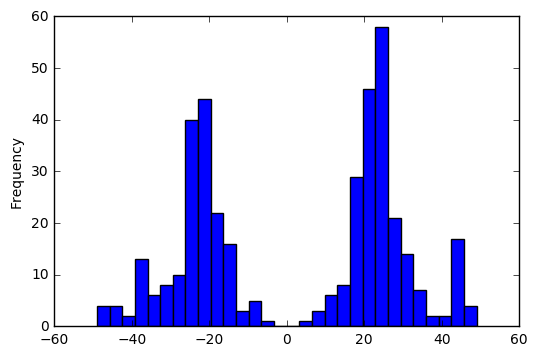

In [55]:
cdf.sdist_aclv2ahex.plot.hist(bins=30)

In [56]:
cdf.head()

,gene_name,transcript_id,seqname,source,sc,clv,strand,gene_source,transcript_source,is_cds_end_NF,is_cds_start_NF,utr_beg,cluster_idx,mclv,mclv0,hexamer,hexamer_id,hexamer_loc0,hexamer_loc,sdist_aclv2ahex
0,ABL1,ENST00000318560,9,protein_coding,133761070,133763062,+,ensembl_havana,ensembl_havana,False,False,133761071,1,133763062,133763061,AATAAA,1,133763038,133763039,23.0
1,AKT1,ENST00000349310,14,protein_coding,105236678,105235686,-,ensembl_havana,ensembl_havana,False,False,105236677,1,105235686,105235685,AATAAA,1,105235704,105235705,-19.0
2,AKT1,ENST00000402615,14,protein_coding,105236678,105235689,-,ensembl_havana,ensembl_havana,False,False,105236677,1,105235686,105235685,AATAAA,1,105235704,105235705,-19.0
3,AKT1,ENST00000407796,14,protein_coding,105236678,105235686,-,ensembl_havana,ensembl_havana,False,False,105236677,1,105235686,105235685,AATAAA,1,105235704,105235705,-19.0
4,AKT1,ENST00000544168,14,protein_coding,105236678,105236492,-,ensembl_havana,ensembl_havana,False,False,105236677,4,105236492,105236491,NA,-1,-1,-1,NaN


In [57]:
cdf.rename(columns={'mclv': 'aclv'}).to_csv('../__results/annotated-clv-sc-mapping.csv', index=False)